In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
from pprint import pprint
sys.path.append('..')

from model import BoxRec, BoxRecConditional
from model import MatrixFactorization, MatrixFactorizationWithBias
from data_loaders.data_processing import JointDataProcessing
from model.box.utils import log1mexp

# Load Models

## Functionalities

In [64]:
def load_model(model_dir):
    arg_dict = json.load(open(model_dir + '/args.json', 'r'))
    if arg_dict['model'] == 'box':
        model = BoxRec(
                n_users=arg_dict['num_users'],
                n_items=arg_dict['num_items'],
                embedding_dim=arg_dict['embedding_dim'],
                volume_temp=arg_dict['volume_temp'],
                intersection_temp=arg_dict['intersection_temp']
        )
    elif arg_dict['model'] == 'box_conditional':
        model = BoxRecConditional(
                n_users=arg_dict['num_users'],
                n_items=arg_dict['num_items'],
                embedding_dim=arg_dict['embedding_dim'],
                volume_temp=arg_dict['volume_temp'],
                intersection_temp=arg_dict['intersection_temp']
        )
    elif arg_dict['model'] == 'mf_bias':
        model = MatrixFactorizationWithBias(
                    n_users=arg_dict['num_users'],
                    n_items=arg_dict['num_items'],
                    embedding_dim=arg_dict['embedding_dim'],
        )
    elif arg_dict['model'] == 'mf':
        model = MatrixFactorization(
                    n_users=arg_dict['num_users'],
                    n_items=arg_dict['num_items'],
                    embedding_dim=arg_dict['embedding_dim'],
        )
    else:
        raise ValueError('Invalid model type')
    model.load_state_dict(torch.load(model_dir + '/model_best_ndcg.pth',
                                     map_location=torch.device('cpu')))
    return model, arg_dict

## Load Box Model attr

In [6]:
box_cond_model_dir = "../model/ml1m/box_conditional/user_attribute_movie/dim_64-negs_10"
model_box_ma, arg_dict_box_ma = load_model(box_cond_model_dir)

## Load Vector Model attribute

In [7]:
vector_model_dir = "../model/ml1m/mf_bias/user_attribute_movie/dim_64-negs_20" ## need to pick from a 128 pool
model_vector_ma, arg_dict_vector_ma = load_model(vector_model_dir)

## Load Box Model Genre

In [65]:
box_cond_model_dir = "../model/ml20m/box_conditional/user_genre_movie/joint/dim_64-negs_5"
model_box_mg, arg_dict_box_mg = load_model(box_cond_model_dir)

## Load Vector Model Genre

In [67]:
vector_model_dir = "../model/ml20m/mf_bias/user_genre_movie/joint/dim_128-negs_20"
model_vector_mg, arg_dict_vector_mg = load_model(vector_model_dir)

# Load dataloader

## functionalities

In [68]:
def gt_df_to_matrix(dataset, gt_df):
    columns = gt_df.columns
    n_rows = len(gt_df[columns[0]].unique())
    n_cols = dataset.n_movies
    gt_matrix = torch.zeros((n_rows, n_cols), dtype=torch.bool)  
    gt_matrix[gt_df[columns[0]], gt_df[columns[1]]] = 1
    return gt_matrix

def get_hr_ndcg_101(scores):
    target_idx = torch.tensor(scores.shape[1] - 1)
    pred_order = torch.argsort(scores, dim=-1, descending=True)
    rank = torch.where(pred_order == target_idx)[1] + 1
    hr_101 = sum(rank <= 10) / len(rank)
    ndcg_101 = sum(1.0 / torch.log2(rank + 1)) / len(rank)
    return hr_101.item(), ndcg_101.item()

def get_hr_ndcg_at_k(rank_list):
    rank_list = np.array(rank_list)
    hr_list = []
    for k in [10, 20, 50]:
        hr = sum(rank_list <= k) / len(rank_list)
        hr_list.append(hr)
        print(f'HR@{k}: {hr}')
    ndcg = sum(1.0 / np.log2(rank_list + 1 + 1)) / len(rank_list)
    print(f'NDCG: {ndcg}')
    return hr_list, ndcg

## Dataloader class

In [69]:
def get_dataset(arg_dict):
    dataset = JointDataProcessing(data_dir='../' + arg_dict['data_dir'],
                                        dataset_type=arg_dict['dataset'],
                                        batch_size=arg_dict['batch_size'])
    return dataset


## Get test and validation numbers
- This is to see if the model loading has worked and if their is any anomaly in the model.
- Also the test numbers will be reported.

#### Functionalities

In [70]:
def check_test_results(dataset, model, mode='valid'):
    if mode == 'valid':
        user_movie_dict = dataset.val_neg_user_movie.to_dict('list')
        attribute_movie_dict = dataset.val_neg_attribute_movie.to_dict('list')
    elif mode == 'test':
        user_movie_dict = dataset.test_neg_user_movie.to_dict('list')
        attribute_movie_dict = dataset.test_neg_attribute_movie.to_dict('list')

    users = [int(x) for x in user_movie_dict.keys()]
    items = [x for x in user_movie_dict.values()]
    users = torch.tensor(users)
    items = torch.tensor(items)
    scores = model(users, items)
    valid_hr, valid_ndcg = get_hr_ndcg_101(scores)

    attributes = [int(x) + dataset.n_users for x in attribute_movie_dict.keys()] ### might be wrong
    items = [x for x in attribute_movie_dict.values()]
    attributes = torch.tensor(attributes)
    items = torch.tensor(items)
    scores = model(attributes, items)
    valid_hr_attr, valid_ndcg_attr = get_hr_ndcg_101(scores)

    return {'hr': valid_hr, 
            'ndcg': valid_ndcg, 
            'hr_attr': valid_hr_attr, 
            'ndcg_attr': valid_ndcg_attr
            }


# Inference

#### Utility Functions

In [71]:
def vector_predict(combination_vector, model):
    all_items = torch.arange(model.n_items)
    item_vectors = model.item_embeddings(all_items)
    scores = (combination_vector * item_vectors).sum(dim=-1)
    return scores

def box_predict(combination_box, model):
    all_items = torch.arange(model.n_items)
    item_boxes = model.item_embeddings(all_items)
    if model.intersection_temp == 0.0:
        scores = combination_box.intersection_log_soft_volume(
            item_boxes, volume_temp=model.volume_temp
        )
    else:
        scores = combination_box.gumbel_intersection_log_volume(
            item_boxes,
            volume_temp=model.volume_temp,
            intersection_temp=model.intersection_temp,
        )
    return scores

def box_predict_conditional(combination_box, model):
    all_items = torch.arange(model.n_items)
    item_boxes = model.item_embeddings(all_items)
    if model.intersection_temp == 0.0:
        intersection_scores = combination_box.intersection_log_soft_volume(
            item_boxes, volume_temp=model.volume_temp
        )
    else:
        intersection_scores = combination_box.gumbel_intersection_log_volume(
            item_boxes,
            volume_temp=model.volume_temp,
            intersection_temp=model.intersection_temp,
        )
    log_volume_items = item_boxes.log_soft_volume_adjusted(volume_temp=model.volume_temp,
                                                      intersection_temp=model.intersection_temp)
    conditional_prob = intersection_scores - log_volume_items
    assert (conditional_prob <= 0).all(), "Log probability can not be positive"
    return conditional_prob

## $U \cap A$

In [72]:
def get_ranking_metrices(query_df,
                         model,
                         arg_dict,
                         gt_matrix,
                         predicted_a_m_matrix,
                         apply_mask = True):

    rank_u_mult_a = []
    rank_u_int_a = []
    rank_a_and_u = []
    for user_id, attribute_id, movie_id in tqdm(zip(query_df['user_id'], query_df['attribute_id'], query_df['movie_id'])):
        u = torch.tensor([user_id])
        a = torch.tensor([attribute_id + n_users])
        m = torch.tensor([movie_id])
        if apply_mask:
            mask = torch.ones(model_vector_mg.n_items, dtype=torch.bool)
            gt_m = torch.where(gt_matrix[user_id, attribute_id] == 1)[0]
            mask[gt_m] = False
            mask[m] = True

        score_u = model.predict_item(u)
        score_a = model.predict_item(a)

        ## Score multiplication
        if arg_dict['model'] == 'box_conditional':
            score_u_mult_a = score_u + score_a
        elif arg_dict['model'] == 'mf_bias':
            score_u_mult_a = F.logsigmoid(score_u) + F.logsigmoid(score_a)
        if apply_mask:
            score_u_mult_a[~mask] = -torch.inf
        order_u_mult_a = torch.argsort(score_u_mult_a, dim=-1, descending=True)

        ## Matrix completion
        a_m = torch.where(predicted_a_m_matrix[attribute_id])[0]
        if m not in a_m:
            rank_a_and_u.append(model.n_items)
        else:
            if apply_mask:
                score_u[~mask] = -torch.inf
            order_u = torch.argsort(score_u, dim=-1, descending=True)
            a_in_u = (order_u[:, None] == a_m).nonzero()[:, 0]
            order_a_in_u = order_u[a_in_u]
            rank_a_and_u.append(torch.where(order_a_in_u == m)[0].item())

        ## Score intersection
        if arg_dict['model'] == 'box_conditional':
            u_box = model.user_embeddings(u)
            a_box = model.user_embeddings(a)
            u_int_a_box = u_box.intersection(a_box)
            u_int_a_box = u_box.intersection(
                        a_box,
                        intersection_temp=model.intersection_temp,
                        bayesian=True)
            u_int_a_scores = box_predict_conditional(u_int_a_box, model)
        elif arg_dict['model'] == 'mf_bias':
            u_vector = model.user_embeddings(u)
            a_vector = model.user_embeddings(a)
            u_int_a_vector = u_vector + a_vector
            u_int_a_scores = vector_predict(u_int_a_vector, model)
        
        if apply_mask:  
            u_int_a_scores[~mask] = -torch.inf
        order_u_int_a = torch.argsort(u_int_a_scores, dim=-1, descending=True)

        # Get ranks
        rank_u_mult_a.append(torch.where(order_u_mult_a == m)[0].item())
        rank_u_int_a.append(torch.where(order_u_int_a == m)[0].item())

    print("Calculating metrics for user*attribute")
    hr_u_mult_a, ndcg_u_mult_a = get_hr_ndcg_at_k(rank_u_mult_a)
    print("Calculating metrics for user intersection attribute")
    hr_u_int_a, ndcg_u_int_a = get_hr_ndcg_at_k(rank_u_int_a)
    print("Calculating metrics for attribute and user threshold")
    hr_a_and_u, ndcg_a_and_u = get_hr_ndcg_at_k(rank_a_and_u)


    return {
            'hr_u_mult_a': hr_u_mult_a, 'ndcg_u_mult_a': ndcg_u_mult_a,
            'hr_u_int_a': hr_u_int_a, 'ndcg_u_int_a': ndcg_u_int_a,
            'hr_a_and_u': hr_a_and_u, 'ndcg_a_and_u': ndcg_a_and_u
            }

## $ U \cap A_1 \cap A_2$

In [73]:
def get_ranking_metrices_intersection(query_df,
                                      model,
                                      arg_dict,
                                      gt_matrix,
                                      predicted_a_m_matrix,
                                      apply_mask=True):
    keep_top = 300
    rank_u_a1_a2_mult = []
    rank_u_a1_a2_int = []
    rank_u_a1_a2_and = []
    for user_id, movie_id, attribute_1, attribute_2 in tqdm(query_df.values):
        u = torch.tensor([user_id])
        m = torch.tensor([movie_id])
        a1 = torch.tensor([attribute_1 + n_users])
        a2 = torch.tensor([attribute_2 + n_users])

        if apply_mask:
            mask = torch.ones(model_vector_mg.n_items, dtype=torch.bool)
            gt_m = torch.where(gt_matrix[user_id, attribute_1, attribute_2] == 1)[0]
            mask[gt_m] = False
            mask[m] = True

        score_u = model.predict_item(u)
        score_a1 = model.predict_item(a1)
        score_a2 = model.predict_item(a2)

        ## Score multiplication
        if arg_dict['model'] == 'box_conditional':
            score_u_a1_a2_mult = score_u + score_a1 + score_a2
        elif arg_dict['model'] == 'mf_bias':
            score_u_a1_a2_mult = F.logsigmoid(score_u) + F.logsigmoid(score_a1) + F.logsigmoid(score_a2)
        
        if apply_mask:
            score_u_a1_a2_mult[~mask] = -torch.inf
        order_u_a1_a2_mult = torch.argsort(score_u_a1_a2_mult, dim=-1, descending=True)

        ## Score intersection
        if arg_dict['model'] == 'box_conditional':
            u_box = model.user_embeddings(u)
            a1_box = model.user_embeddings(a1)
            a2_box = model.user_embeddings(a2)
            u_int_a1_box = u_box.intersection(
                a1_box,
                intersection_temp=arg_dict['intersection_temp'],
                bayesian=True)
            u_a1_a2_int_box = u_int_a1_box.intersection(
                a2_box,
                intersection_temp=arg_dict['intersection_temp'],
                bayesian=True)
            u_a1_a2_scores = box_predict_conditional(u_a1_a2_int_box, model)
        elif arg_dict['model'] == 'mf_bias':
            u_vector = model.user_embeddings(u)
            a1_vector = model.user_embeddings(a1)
            a2_vector = model.user_embeddings(a2)
            u_a1_a2_vector = u_vector + a1_vector + a2_vector
            u_a1_a2_scores = vector_predict(u_a1_a2_vector, model)
        
        if apply_mask:
            u_a1_a2_scores[~mask] = -torch.inf
        order_u_a1_a2_int = torch.argsort(u_a1_a2_scores, dim=-1, descending=True)

        ## Matrix completion
        a1_m = torch.where(predicted_a_m_matrix[attribute_1])[0].tolist()
        a2_m = torch.where(predicted_a_m_matrix[attribute_2])[0].tolist()
        a1_a2_m = set(a1_m).intersection(set(a2_m))
        if m.item() not in a1_a2_m:
            rank_u_a1_a2_and.append(model.n_items)
        else:
            if apply_mask:
                score_u[~mask] = -torch.inf
            order_u = torch.argsort(score_u, dim=-1, descending=True)
            a1_a2_m = torch.tensor(list(a1_a2_m))
            a1_a2_in_u = (order_u[:, None] == a1_a2_m).nonzero()[:, 0]
            order_a1_a2_in_u = order_u[a1_a2_in_u]
            rank_u_a1_a2_and.append(torch.where(order_a1_a2_in_u == m)[0].item())


        ## get ranks
        rank_u_a1_a2_mult.append(torch.where(order_u_a1_a2_mult == m)[0].item())
        rank_u_a1_a2_int.append(torch.where(order_u_a1_a2_int == m)[0].item())

    print("Post hoc filtering")
    hr_u_a1_a2_and, ndcg_u_a1_a2_and = get_hr_ndcg_at_k(rank_u_a1_a2_and)
    print("Calculating metrics for user*attribute1*attribute2")
    hr_u_a1_a2_mult, ndcg_u_a1_a2_mult = get_hr_ndcg_at_k(rank_u_a1_a2_mult)
    print("Calculating metrics for user intersection attribute1 intersection attribute2")
    hr_u_a1_a2_int, ndcg_u_a1_a2_int = get_hr_ndcg_at_k(rank_u_a1_a2_int)

    return {
            'hr_u_a1_a2_mult': hr_u_a1_a2_mult, 'ndcg_u_a1_a2_mult': ndcg_u_a1_a2_mult,
            'hr_u_a1_a2_int': hr_u_a1_a2_int, 'ndcg_u_a1_a2_int': ndcg_u_a1_a2_int,
            'hr_u_a1_a2_and': hr_u_a1_a2_and, 'ndcg_u_a1_a2_and': ndcg_u_a1_a2_and
            }

## $ U \cap A_1 \cap \neg A_2$

In [74]:
def get_ranking_metrices_difference(query_df,
                                    model,
                                    arg_dict,
                                    gt_matrix,
                                    predicted_a_m_matrix,
                                    apply_mask=True):
    keep_top = 300
    rank_u_a1_not_a2_mult = []
    rank_u_a1_not_a2_int = []
    rank_u_a1_not_a2_and = []
    for user_id, movie_id, attribute_1, attribute_2 in tqdm(query_df.values):
        u = torch.tensor([user_id])
        m = torch.tensor([movie_id])
        a1 = torch.tensor([attribute_1 + n_users])
        a2 = torch.tensor([attribute_2 + n_users])

        if apply_mask:
            mask = torch.ones(model_vector_mg.n_items, dtype=torch.bool)
            gt_m = torch.where(gt_matrix[user_id, attribute_1, attribute_2] == 1)[0]
            mask[gt_m] = False
            mask[m] = True

        score_u = model.predict_item(u)
        score_a1 = model.predict_item(a1)
        score_a2 = model.predict_item(a2)
        

        ## Score Multiplication
        if arg_dict['model'] == 'box_conditional':
            score_u_a1_not_a2_mult = score_u + score_a1 + log1mexp(score_a2)
        elif arg_dict['model'] == 'mf_bias':
            score_u_a1_not_a2_mult = F.logsigmoid(score_u) + F.logsigmoid(score_a1) + F.logsigmoid(-score_a2)
        
        if apply_mask:
            score_u_a1_not_a2_mult[~mask] = -torch.inf
        order_u_a1_not_a2_mult = torch.argsort(score_u_a1_not_a2_mult, dim=-1, descending=True)

        ## Score Set Operations
        if arg_dict['model'] == 'box_conditional':
            u_box = model.user_embeddings(u)
            a1_box = model.user_embeddings(a1)
            a2_box = model.user_embeddings(a2)
            u_int_a1_box = u_box.intersection(
                a1_box,
                intersection_temp=model.intersection_temp,
                bayesian=True)
            u_a1_a2_int_box = u_int_a1_box.intersection(
                a2_box,
                intersection_temp=model.intersection_temp,
                bayesian=True)
        
            u_a1_a2_scores = box_predict_conditional(u_a1_a2_int_box, model)
            u_a1_scores = box_predict_conditional(u_int_a1_box, model)
            scores_u_a1_not_a2_int = u_a1_scores + log1mexp(u_a1_a2_scores)
        elif arg_dict['model'] == 'mf_bias':
            u_vector = model.user_embeddings(u)
            a1_vector = model.user_embeddings(a1)
            a2_vector = model.user_embeddings(a2)
            u_a1_not_a2_vector = u_vector + a1_vector - a2_vector
            scores_u_a1_not_a2_int = vector_predict(u_a1_not_a2_vector, model)
        
        if apply_mask:
            scores_u_a1_not_a2_int[~mask] = -torch.inf
        order_u_a1_not_a2_int = torch.argsort(scores_u_a1_not_a2_int, dim=-1, descending=True)

        ## Matrix completion
        a1_m = torch.where(predicted_a_m_matrix[attribute_1])[0].tolist()
        a2_m = torch.where(predicted_a_m_matrix[attribute_2])[0].tolist()
        a1_not_a2_m = set(a1_m).difference(set(a2_m))
        
        if m not in a1_not_a2_m:
            rank_u_a1_not_a2_and.append(model.n_items)
        else:
            if apply_mask:
                score_u[~mask] = -torch.inf
            order_u = torch.argsort(score_u, dim=-1, descending=True)
            a1_not_a2_in_u = (order_u[:, None] == torch.tensor(list(a1_not_a2_m))).nonzero()[:, 0]
            order_a1_not_a2_in_u = order_u[a1_not_a2_in_u]
            rank_u_a1_not_a2_and.append(torch.where(order_a1_not_a2_in_u == m)[0].item())
        
        ## get ranks
        rank_u_a1_not_a2_mult.append(torch.where(order_u_a1_not_a2_mult == m)[0].item())
        rank_u_a1_not_a2_int.append(torch.where(order_u_a1_not_a2_int == m)[0].item())
    
    print("Post hoc filtering")
    hr_u_a1_not_a2_and, ndcg_u_a1_not_a2_and = get_hr_ndcg_at_k(rank_u_a1_not_a2_and)

    print("Calculating metrics for user*attribute1-not-attribute2")
    hr_u_a1_not_a2_mult, ndcg_u_a1_not_a2_mult = get_hr_ndcg_at_k(rank_u_a1_not_a2_mult)
    print("Calculating metrics for user intersection attribute1 - intersection attribute2")
    hr_u_a1_not_a2_int, ndcg_u_a1_not_a2_int = get_hr_ndcg_at_k(rank_u_a1_not_a2_int)

    return {
            'hr_u_a1_not_a2_mult': hr_u_a1_not_a2_mult, 'ndcg_u_a1_not_a2_mult': ndcg_u_a1_not_a2_mult,
            'hr_u_a1_not_a2_int': hr_u_a1_not_a2_int, 'ndcg_u_a1_not_a2_int': ndcg_u_a1_not_a2_int,
            'hr_u_a1_not_a2_and': hr_u_a1_not_a2_and, 'ndcg_u_a1_not_a2_and': ndcg_u_a1_not_a2_and
            }


# Get Results for Movie-Genre (MG) Joint Matrix

In [75]:
dataset_mg = get_dataset(arg_dict_box_mg)
n_users = dataset_mg.n_users
n_movies = dataset_mg.n_movies
n_attributes = dataset_mg.n_attributes
gt_user_movie_matrix_mg = gt_df_to_matrix(dataset_mg, dataset_mg.gt_user_movie)
gt_attribute_movie_matrix_mg = gt_df_to_matrix(dataset_mg, dataset_mg.gt_attribute_movie)
dataset_mg.read_neg_data_files()
print('Data loaded')
print('Number of users:', n_users)
print('Number of movies:', n_movies)
print('Number of attributes:', n_attributes)
user_attribute_query_mg = pd.read_csv('../' + arg_dict_box_mg['data_dir'] + '/combinations/user_attribute.csv')
user_attributeA_attributeB_mg = pd.read_csv('../' + arg_dict_box_mg['data_dir'] + '/combinations/user_attributeA_attributeB.csv')
user_attributeA_not_attributeB_mg = pd.read_csv('../' + arg_dict_box_mg['data_dir'] + '/combinations/user_attributeA_not_attributeB.csv')
print("Combination queries loaded")

Data files read successfully...
ID files read successfully...
Negative data files read successfully...
Data loaded
Number of users: 138493
Number of movies: 26744
Number of attributes: 95
Combination queries loaded


In [76]:
print("Validation results for box model")
pprint(check_test_results(dataset_mg, model_box_mg))
print("Validation results for vector model")
pprint(check_test_results(dataset_mg, model_vector_mg))

Validation results for box model
{'hr': 0.9414096474647522,
 'hr_attr': 0.8648648858070374,
 'ndcg': 0.7325978875160217,
 'ndcg_attr': 0.6610234975814819}
Validation results for vector model
{'hr': 0.9743359684944153,
 'hr_attr': 0.5810810923576355,
 'ndcg': 0.7017239332199097,
 'ndcg_attr': 0.3932837247848511}


### Trying out

In [17]:
import torch

In [59]:
def score_all_items(user, model):
    all_items = torch.arange(model.n_items)
    item_vectors = model.item_embeddings(all_items)
    user_vector = model.user_embeddings(user)
    scores = torch.matmul(user_vector, item_vectors.T)
    user_bias = model.user_biases(user)
    item_biases = model.item_biases(all_items)
    scores += user_bias + item_biases.T + model.global_bias
    return scores

In [60]:
u = torch.tensor(user_attribute_query_mg['user_id'])
a = torch.tensor(user_attribute_query_mg['genre_id'] + n_users)
m = torch.tensor(user_attribute_query_mg['movie_id'])

u_embedding = model_vector_mg.user_embeddings(u)
a_embedding = model_vector_mg.user_embeddings(a)
all_item_embedding = model_vector_mg.item_embeddings(torch.arange(model_vector_mg.n_items))

score_u = score_all_items(u, model_vector_mg)
score_a = score_all_items(a, model_vector_mg)

#mask 



### Get GT

In [1]:
gt_u_and_a_matrix_mg = gt_user_movie_matrix_mg[:, None] & gt_attribute_movie_matrix_mg
gt_u_and_a1_a2_matrix_mg = gt_u_and_a_matrix_mg[:,:,None,:] & gt_attribute_movie_matrix_mg
gt_u_and_a1_not_a2_matrix_mg = gt_u_and_a_matrix_mg[:,:,None,:] & ~gt_attribute_movie_matrix_mg
# #shape
# gt_u_and_a_matrix_mg.shape, gt_u_and_a1_a2_matrix_mg.shape, gt_u_and_a1_not_a2_matrix_mg.shape

NameError: name 'gt_user_movie_matrix_mg' is not defined

In [ ]:
u = torch.where(gt_u_and_a_matrix_mg)[0]
a = torch.where(gt_u_and_a_matrix_mg)[1]
m = torch.where(gt_u_and_a_matrix_mg)[2]
for i in range(len(u)):
    assert gt_user_movie_matrix_mg[u[i], m[i]] == 1
    assert gt_attribute_movie_matrix_mg[a[i], m[i]] == 1


## Direct Filtering model

In [67]:
from torcheval.metrics.functional import binary_f1_score
def get_best_f1_theshold(input, target):
    max_f1 = 0
    best_threshold = 0
    for threshold in input:
        thresholded_score = (input >= threshold).float()
        f1 = binary_f1_score(thresholded_score, target)
        if f1 > max_f1:
            max_f1 = f1
            best_threshold = threshold
    return best_threshold, max_f1

In [68]:
train_user_movie_mg = dataset_mg.train_user_movie
train_user_movie_matrix_mg = gt_df_to_matrix(dataset_mg, train_user_movie_mg)
train_attribute_movie_mg = dataset_mg.train_attribute_movie
train_attribute_movie_matrix_mg = gt_df_to_matrix(dataset_mg, train_attribute_movie_mg)

In [265]:
def get_matrix_completion(model, train_matrix):
    predicted_matrix = []
    for i in tqdm(range(n_attributes)):
        attribute = torch.tensor([i + n_users])
        scores = model.predict_item(attribute)
        target = train_matrix[i]
        threshold, f1 = get_best_f1_theshold(scores, target)
        predicted_matrix.append(scores >= threshold)
    return torch.stack(predicted_matrix)

In [266]:
predicted_a_m_box_mg = get_matrix_completion(model_box_mg, train_attribute_movie_matrix_mg)
predicted_a_m_vector_mg = get_matrix_completion(model_vector_mg, train_attribute_movie_matrix_mg)
print(predicted_a_m_box_mg.sum() / train_attribute_movie_matrix_mg.sum(), " times more entries")
print(predicted_a_m_vector_mg.sum() / train_attribute_movie_matrix_mg.sum(), " times more entries")

100%|██████████| 57/57 [00:21<00:00,  2.68it/s]

tensor(1.0636)  times more entries
tensor(1.4355)  times more entries


## BOX U A - Genre

In [268]:
metric_dict_box_mg = get_ranking_metrices(user_attribute_query_mg,
                                          model_box_mg,
                                          arg_dict_box_mg,
                                          gt_u_and_a_matrix_mg,
                                          predicted_a_m_box_mg,
                                          apply_mask = True)

100%|██████████| 38181/38181 [17:26<00:00, 36.48it/s]

Calculating metrics for user*attribute
HR@10: 0.09952594222257144
HR@20: 0.1669154815222231
HR@50: 0.31481626987244965
NDCG: 0.18066594216394696
Calculating metrics for user intersection attribute
HR@10: 0.10979282889395249
HR@20: 0.1826039129409916
HR@50: 0.34160970116026296
NDCG: 0.18647794214704116
Calculating metrics for attribute and user threshold
HR@10: 0.11681202692438647
HR@20: 0.1909588538802022
HR@50: 0.32311882873680625
NDCG: 0.16770329181262164


## Vector U A - Genre

In [267]:
metric_dict_vector_mg = get_ranking_metrices(user_attribute_query_mg,
                                             model_vector_mg,
                                             arg_dict_vector_mg,
                                             gt_u_and_a_matrix_mg,
                                             predicted_a_m_vector_mg,
                                             apply_mask=True
                                    )

100%|██████████| 38181/38181 [03:27<00:00, 183.98it/s]


Calculating metrics for user*attribute
HR@10: 0.03619601372410361
HR@20: 0.07660878447395301
HR@50: 0.19226840575155182
NDCG: 0.1513329949401536
Calculating metrics for user intersection attribute
HR@10: 0.009533537623425264
HR@20: 0.020088525706503234
HR@50: 0.05620596631832587
NDCG: 0.12377377183332954
Calculating metrics for attribute and user threshold
HR@10: 0.0477462612294073
HR@20: 0.09897593043660459
HR@50: 0.21921898326392708
NDCG: 0.1358223628800166


## BOX U A1 A2 -Genre

In [269]:
metric_dict_box_mg_a1_a2 = get_ranking_metrices_intersection(user_attributeA_attributeB_mg,
                                                             model_box_mg,
                                                             arg_dict_box_mg,
                                                             gt_u_and_a1_a2_matrix_mg,
                                                                predicted_a_m_box_mg,
                                                             apply_mask=True)

100%|██████████| 72048/72048 [39:22<00:00, 30.49it/s]  


Post hoc filtering
HR@10: 0.14506995336442371
HR@20: 0.2047940262047524
HR@50: 0.28546246946480125
NDCG: 0.16523006606589666
Calculating metrics for user*attribute1*attribute2
HR@10: 0.10647068620919387
HR@20: 0.17832556073728625
HR@50: 0.34229957805907174
NDCG: 0.18642827214179472
Calculating metrics for user intersection attribute1 intersection attribute2
HR@10: 0.16848489895625138
HR@20: 0.26612813679769043
HR@50: 0.46135909393737506
NDCG: 0.2149270363052428


## Vector U A1 A2 - Genre

In [270]:
metric_dict_vector_mg_a1_a2 = get_ranking_metrices_intersection(user_attributeA_attributeB_mg,
                                                                model_vector_mg,
                                                                arg_dict_vector_mg,
                                                             gt_u_and_a1_a2_matrix_mg,
                                                                predicted_a_m_box_mg,
                                                             apply_mask=True)

100%|██████████| 72048/72048 [07:53<00:00, 152.15it/s]


Post hoc filtering
HR@10: 0.11284143904063958
HR@20: 0.17752054186098157
HR@50: 0.2744975571840995
NDCG: 0.15015795963918993
Calculating metrics for user*attribute1*attribute2
HR@10: 0.037211303575394185
HR@20: 0.08140406395736176
HR@50: 0.21652231845436376
NDCG: 0.15651284239164867
Calculating metrics for user intersection attribute1 intersection attribute2
HR@10: 0.002512214079502554
HR@20: 0.006578947368421052
HR@50: 0.025205418609815677
NDCG: 0.11766421036803082


## BOX $U \cap A1 \cap \neg A2$ - Genre

In [271]:
metric_dict_box_mg_a1_not_a2 = get_ranking_metrices_difference(user_attributeA_not_attributeB_mg,
                                                               model_box_mg,
                                                               arg_dict_box_mg,
                                                               gt_u_and_a1_not_a2_matrix_mg,
                                                                predicted_a_m_box_mg,
                                                               apply_mask=True)

100%|██████████| 61969/61969 [42:46<00:00, 24.14it/s]  


Post hoc filtering
HR@10: 0.0
HR@20: 0.0
HR@50: 0.0
NDCG: 0.08434245191229335
Calculating metrics for user*attribute1-not-attribute2
HR@10: 0.08893156255547129
HR@20: 0.15159192499475543
HR@50: 0.2937597831173651
NDCG: 0.17767775514200776
Calculating metrics for user intersection attribute1 - intersection attribute2
HR@10: 0.08622052961964853
HR@20: 0.15122077167616066
HR@50: 0.30691152027626717
NDCG: 0.17855928591058665


## Vector  $U \cap A_1 \cap \neg A_2$  -Genre

In [272]:
metric_dict_vector_mg_a1_not_a2 = get_ranking_metrices_difference(user_attributeA_not_attributeB_mg,
                                                                  model_vector_mg,
                                                                  arg_dict_vector_mg,
                                                                  gt_u_and_a1_not_a2_matrix_mg,
                                                                  predicted_a_m_box_mg,
                                                                  apply_mask=True)

100%|██████████| 61969/61969 [06:31<00:00, 158.12it/s]


Post hoc filtering
HR@10: 0.0
HR@20: 0.0
HR@50: 0.0
NDCG: 0.08434245191229335
Calculating metrics for user*attribute1-not-attribute2
HR@10: 0.02880472494311672
HR@20: 0.06464522583872581
HR@50: 0.17479707595733351
NDCG: 0.1500680664228702
Calculating metrics for user intersection attribute1 - intersection attribute2
HR@10: 0.004824993141732156
HR@20: 0.011134599557843438
HR@50: 0.03916474366215366
NDCG: 0.12046664684866694


### Analysis

In [174]:
user_attributeA_attributeB_mg.values[8990]

array([ 58, 227,   0,   1])

In [ ]:
count = 0
count_opp = 0
for user_id, movie_id, attribute_1, attribute_2 in user_attributeA_attributeB_mg.values:
   
    u = torch.tensor([user_id])
    m = torch.tensor([movie_id])
    a1 = torch.tensor([attribute_1 + n_users])
    a2 = torch.tensor([attribute_2 + n_users])

    mask = torch.ones(model_vector_mg.n_items, dtype=torch.bool)
    gt_m = torch.where(gt_u_and_a1_a2_matrix_mg[user_id, attribute_1, attribute_2] == 1)[0]
    mask[gt_m] = False
    mask[m] = True

    movie_name = dataset_mg.movies[dataset_mg.movies['movie_id'] == movie_id]['movie'].item()
    attr_1_name = dataset_mg.attributes[dataset_mg.attributes['genre_id'] == attribute_1]['genre'].item()
    attr_2_name = dataset_mg.attributes[dataset_mg.attributes['genre_id'] == attribute_2]['genre'].item()
    # print(f"User: {user_id}, Movie: {movie_name}, Attribute 1: {attr_1_name}, Attribute 2: {attr_2_name}")

    score_u = model_box_mg.predict_item(u)
    score_a1 = model_box_mg.predict_item(a1)
    score_a2 = model_box_mg.predict_item(a2)

    user_movie_rank = torch.where(torch.argsort(score_u, dim=-1, descending=True) == m)[0].item()
    attr1_movie_rank = torch.where(torch.argsort(score_a1, dim=-1, descending=True) == m)[0].item()
    attr2_movie_rank = torch.where(torch.argsort(score_a2, dim=-1, descending=True) == m)[0].item()
    # print(f"Rank of movie in user: {user_movie_rank}")
    # print(f"Rank of movie in attribute 1: {attr1_movie_rank}")
    # print(f"Rank of movie in attribute 2: {attr2_movie_rank}")

    joint_score = score_u + score_a1 + score_a2
    joint_score[~mask] = -torch.inf

    joint_rank = torch.where(torch.argsort(joint_score, dim=-1, descending=True) == m)[0].item()
    # print(f"Rank of movie in user*attribute1*attribute2: {joint_rank}")

    u_box = model_box_mg.user_embeddings(u)
    a1_box = model_box_mg.user_embeddings(a1)
    a2_box = model_box_mg.user_embeddings(a2)
    u_int_a1_box = u_box.intersection(
        a1_box,
        intersection_temp=model_box_mg.intersection_temp,
        bayesian=True)
    u_int_a1_a2_box = u_int_a1_box.intersection(
        a2_box,
        intersection_temp=model_box_mg.intersection_temp,
        bayesian=True)

    int_scores = box_predict_conditional(u_int_a1_a2_box, model_box_mg)
    int_scores[~mask] = -torch.inf
    int_rank = torch.where(torch.argsort(int_scores, dim=-1, descending=True) == m)[0].item()
    # print(f"Rank of movie in user intersection attribute1 intersection attribute2: {int_rank}")
    if int_rank < joint_rank:
        count+=1
        if int_rank < 10 and joint_rank > 50:
            print("-------------------------------")
            print(f"User: {user_id}, movie_id: {movie_id}, Attr_1_id: {attribute_1}, attr_2_id {attribute_2}")
            print(f"Movie: {movie_name}, Attribute 1: {attr_1_name}, Attribute 2: {attr_2_name}")
            print(f"int_rank {int_rank}, joint_rank {joint_rank}")
    else:
        count_opp+=1     


In [205]:
attr_df = dataset_mg.attributes
movie_df = dataset_mg.movies
user_id = 15
movie_id = 58
attribute_1 = 1
attribute_2 = 13
u = torch.tensor([user_id])
m = torch.tensor([movie_id])
a1 = torch.tensor([attribute_1 + n_users])
a2 = torch.tensor([attribute_2 + n_users])

mask = torch.ones(model_vector_mg.n_items, dtype=torch.bool)
gt_m = torch.where(gt_u_and_a1_a2_matrix_mg[user_id, attribute_1, attribute_2] == 1)[0]
mask[gt_m] = False
mask[m] = True

movie_name = movie_df[movie_df['movie_id'] == movie_id]['movie'].item()
attr_1_name = attr_df[attr_df['genre_id'] == attribute_1]['genre'].item()
attr_2_name = attr_df[attr_df['genre_id'] == attribute_2]['genre'].item()
print(f"User: {user_id}, Movie: {movie_name}, Attribute 1: {attr_1_name}, Attribute 2: {attr_2_name}")

score_u = model_box_mg.predict_item(u)
score_a1 = model_box_mg.predict_item(a1)
score_a2 = model_box_mg.predict_item(a2)

user_movie_rank = torch.where(torch.argsort(score_u, dim=-1, descending=True) == m)[0].item()
attr1_movie_rank = torch.where(torch.argsort(score_a1, dim=-1, descending=True) == m)[0].item()
attr2_movie_rank = torch.where(torch.argsort(score_a2, dim=-1, descending=True) == m)[0].item()
# print(f"Rank of movie in user: {user_movie_rank}")
# print(f"Rank of movie in attribute 1: {attr1_movie_rank}")
# print(f"Rank of movie in attribute 2: {attr2_movie_rank}")

joint_score = score_u + score_a1 + score_a2
joint_score[~mask] = -torch.inf

joint_rank = torch.where(torch.argsort(joint_score, dim=-1, descending=True) == m)[0].item()
# print(f"Rank of movie in user*attribute1*attribute2: {joint_rank}")

u_box = model_box_mg.user_embeddings(u)
a1_box = model_box_mg.user_embeddings(a1)
a2_box = model_box_mg.user_embeddings(a2)
u_int_a1_box = u_box.intersection(
    a1_box,
    intersection_temp=model_box_mg.intersection_temp,
    bayesian=True)
u_int_a1_a2_box = u_int_a1_box.intersection(
    a2_box,
    intersection_temp=model_box_mg.intersection_temp,
    bayesian=True)

int_scores = box_predict_conditional(u_int_a1_a2_box, model_box_mg)
int_scores[~mask] = -torch.inf
int_rank = torch.where(torch.argsort(int_scores, dim=-1, descending=True) == m)[0].item()

top_10_int = torch.argsort(int_scores, dim=-1, descending=True)[:30]
top_10_joint = torch.argsort(joint_score, dim=-1, descending=True)[:30]

for i, id in enumerate(top_10_int):
    print(i, ' : ', movie_df[movie_df['movie_id'] == id.item()]['movie'].item(), ':', id)
print("----------------------------------------")
for i, id in enumerate(top_10_joint):
    print(i, ' : ', movie_df[movie_df['movie_id'] == id.item()]['movie'].item(), ':', id)


User: 15, Movie: Toy Story 2 (1999), Attribute 1: comedy, Attribute 2: children
0  :  Santa Clause, The (1994) : tensor(454)
1  :  Pollyanna (1960) : tensor(1772)
2  :  Three Musketeers, The (1993) : tensor(581)
3  :  Batman Forever (1995) : tensor(331)
4  :  Willy Wonka and the Chocolate Factory (1971) : tensor(107)
5  :  Home Alone 3 (1997) : tensor(1666)
6  :  Toy Story 2 (1999) : tensor(58)
7  :  Crocodile Dundee II (1988) : tensor(772)
8  :  Herbie Goes to Monte Carlo (1977) : tensor(2003)
9  :  Absent Minded Professor, The (1961) : tensor(843)
10  :  D2: The Mighty Ducks (1994) : tensor(1460)
11  :  Honey, I Blew Up the Kid (1992) : tensor(839)
12  :  Popeye (1980) : tensor(669)
13  :  Dragonheart (1996) : tensor(492)
14  :  Aladdin and the King of Thieves (1996) : tensor(1386)
15  :  Jungle Book, The (1994) : tensor(1250)
16  :  Steamboat Willie (1940) : tensor(1443)
17  :  Rescuers, The (1977) : tensor(1217)
18  :  Kid in King Arthur's Court, A (1995) : tensor(1718)
19  :  Dumb

In [246]:
attr_df = dataset_mg.attributes
movie_df = dataset_mg.movies
user_id = 15
movie_id = 58
attribute_1 = 1
attribute_2 = 13
u = torch.tensor([user_id])
m = torch.tensor([movie_id])
a1 = torch.tensor([attribute_1 + n_users])
a2 = torch.tensor([attribute_2 + n_users])

mask = torch.ones(model_vector_mg.n_items, dtype=torch.bool)
gt_m = torch.where(gt_u_and_a1_a2_matrix_mg[user_id, attribute_1, attribute_2] == 1)[0]
mask[gt_m] = False
mask[m] = True

movie_name = movie_df[movie_df['movie_id'] == movie_id]['movie'].item()
attr_1_name = attr_df[attr_df['genre_id'] == attribute_1]['genre'].item()
attr_2_name = attr_df[attr_df['genre_id'] == attribute_2]['genre'].item()
print(f"User: {user_id}, Movie: {movie_name}, Attribute 1: {attr_1_name}, Attribute 2: {attr_2_name}")

score_u = model_box_mg.predict_item(u)
score_a1 = model_box_mg.predict_item(a1)
score_a2 = model_box_mg.predict_item(a2)
score_u[~mask] = -torch.inf
score_a1[~mask] = -torch.inf
score_a2[~mask] = -torch.inf
order_a1 = torch.argsort(score_a1, dim=-1, descending=True)
order_a2 = torch.argsort(score_a2, dim=-1, descending=True)

a1_m = torch.where(predicted_a_m_box_mg[attribute_1])[0].tolist()
a2_m = torch.where(predicted_a_m_box_mg[attribute_2])[0].tolist()
a1_a2_m = set(a1_m).intersection(set(a2_m))

score_u[~mask] = -torch.inf
order_u = torch.argsort(score_u, dim=-1, descending=True)
a1_a2_m = torch.tensor(list(a1_a2_m))
a1_a2_in_u = (order_u[:, None] == a1_a2_m).nonzero()[:, 0]
order_a1_a2_in_u = order_u[a1_a2_in_u]
rank = torch.where(order_a1_a2_in_u == m)
user_rank = torch.where(order_u == m)
print(user_rank)
print(rank)

User: 15, Movie: Toy Story 2 (1999), Attribute 1: comedy, Attribute 2: children
(tensor([957]),)
(tensor([951]),)


In [249]:
set(order_u.tolist()).intersection(set(order_a1.tolist()[:1000])).intersection(set(order_a2.tolist()[:300]))

{228,
 331,
 339,
 384,
 581,
 601,
 666,
 669,
 670,
 725,
 772,
 775,
 778,
 855,
 905,
 1041,
 1042,
 1117,
 1127,
 1142,
 1288,
 1334,
 1394,
 1413,
 1460,
 1486,
 1553,
 1608,
 1609,
 1638,
 1666,
 1706,
 1718,
 1772,
 1779,
 1825,
 1878,
 1925,
 1978,
 2003,
 2103,
 2283,
 2452,
 2647,
 2733,
 2864,
 3118,
 3256}

In [251]:
rank_fixed_100 =[]
rank_fixed_200 = []
rank_fixed_500 = []
rank_fixed_1000 = []
rank_u_and_a = []
rank_only_a = []
for user_id, attribute_id, movie_id in tqdm(user_attribute_query_mg.values):
    u = torch.tensor([user_id])
    a = torch.tensor([attribute_id + n_users])
    m = torch.tensor([movie_id])

    mask = torch.ones(model_vector_mg.n_items, dtype=torch.bool)
    gt_m = torch.where(gt_u_and_a_matrix_mg[user_id, attribute_id] == 1)[0]
    mask[gt_m] = False
    mask[m] = True

    score_u = model_box_mg.predict_item(u)
    score_a = model_box_mg.predict_item(a)
    score_u[~mask] = -torch.inf
    score_a[~mask] = -torch.inf
    order_m = torch.argsort(score_a, dim=-1, descending=True)
    top_100_a_m = order_m[:100]
    top_200_a_m = order_m[:200]
    top_500_a_m = order_m[:500]
    top_1000_a_m = order_m[:1000]
    a_m = torch.where(predicted_a_m_box_mg[attribute_id])[0]
    break
#     if m not in 
#     if m not in a_m:
#         rank_a_and_u.append(model.n_items)
#     else:
#         if apply_mask:
#             score_u[~mask] = -torch.inf
#         order_u = torch.argsort(score_u, dim=-1, descending=True)
#         a_in_u = (order_u[:, None] == a_m).nonzero()[:, 0]
#         order_a_in_u = order_u[a_in_u]
#         rank_a_and_u.append(torch.where(order_a_in_u == m)[0].item())

#     # Get ranks
#     rank_u_mult_a.append(torch.where(order_u_mult_a == m)[0].item())
#     rank_u_int_a.append(torch.where(order_u_int_a == m)[0].item())

# print("Calculating metrics for user*attribute")
# hr_u_mult_a, ndcg_u_mult_a = get_hr_ndcg_at_k(rank_u_mult_a)
# print("Calculating metrics for user intersection attribute")
# hr_u_int_a, ndcg_u_int_a = get_hr_ndcg_at_k(rank_u_int_a)
# print("Calculating metrics for attribute and user threshold")
# hr_a_and_u, ndcg_a_and_u = get_hr_ndcg_at_k(rank_a_and_u)


  0%|          | 0/38181 [00:00<?, ?it/s]


In [285]:
rank_u_a1_a2_and = []
rank_u_a1_a2_mult = []
rank_u_a1_a2_int = []

for user_id, movie_id, attribute_1, attribute_2 in tqdm(user_attributeA_attributeB_mg.values):
    u = torch.tensor([user_id])
    m = torch.tensor([movie_id])
    a1 = torch.tensor([attribute_1 + n_users])
    a2 = torch.tensor([attribute_2 + n_users])


    mask = torch.ones(model_vector_mg.n_items, dtype=torch.bool)
    gt_m = torch.where(gt_u_and_a1_a2_matrix_mg[user_id, attribute_1, attribute_2] == 1)[0]
    mask[gt_m] = False
    mask[m] = True

    score_u = model_box_mg.predict_item(u)
    score_a1 = model_box_mg.predict_item(a1)
    score_a2 = model_box_mg.predict_item(a2)

    ## Score multiplication
    if arg_dict_box_mg['model'] == 'box_conditional':
        score_u_a1_a2_mult = score_u + score_a1 + score_a2
    elif arg_dict_box_mg['model'] == 'mf_bias':
        score_u_a1_a2_mult = F.logsigmoid(score_u) + F.logsigmoid(score_a1) + F.logsigmoid(score_a2)
    

    score_u_a1_a2_mult[~mask] = -torch.inf
    order_u_a1_a2_mult = torch.argsort(score_u_a1_a2_mult, dim=-1, descending=True)

    ## Score intersection
    if arg_dict_box_mg['model'] == 'box_conditional':
        u_box = model_box_mg.user_embeddings(u)
        a1_box = model_box_mg.user_embeddings(a1)
        a2_box = model_box_mg.user_embeddings(a2)
        u_int_a1_box = u_box.intersection(
            a1_box,
            intersection_temp=arg_dict_box_mg['intersection_temp'],
            bayesian=True)
        u_a1_a2_int_box = u_int_a1_box.intersection(
            a2_box,
            intersection_temp=arg_dict_box_mg['intersection_temp'],
            bayesian=True)
        u_a1_a2_scores = box_predict_conditional(u_a1_a2_int_box, model_box_mg)
    elif arg_dict_box_mg['model'] == 'mf_bias':
        u_vector = model_vector_mg.user_embeddings(u)
        a1_vector = model_vector_mg.user_embeddings(a1)
        a2_vector = model_vector_mg.user_embeddings(a2)
        u_a1_a2_vector = u_vector + a1_vector + a2_vector
        u_a1_a2_scores = vector_predict(u_a1_a2_vector, model_vector_mg)
    

    u_a1_a2_scores[~mask] = -torch.inf
    order_u_a1_a2_int = torch.argsort(u_a1_a2_scores, dim=-1, descending=True)
            ## get ranks
    rank_u_a1_a2_mult.append(torch.where(order_u_a1_a2_mult == m)[0].item())
    rank_u_a1_a2_int.append(torch.where(order_u_a1_a2_int == m)[0].item())
    ## Matrix completion
    a1_m = torch.where(predicted_a_m_box_mg[attribute_1])[0].tolist()
    a2_m = torch.where(predicted_a_m_box_mg[attribute_2])[0].tolist()
    a1_a2_m = set(a1_m).intersection(set(a2_m))
    if m.item() not in a1_a2_m:
        rank_u_a1_a2_and.append(model_box_mg.n_items)
    else:
        score_u[~mask] = -torch.inf
        order_u = torch.argsort(score_u, dim=-1, descending=True)
        a1_a2_m = torch.tensor(list(a1_a2_m))
        a1_a2_in_u = (order_u[:, None] == a1_a2_m).nonzero()[:, 0]
        order_a1_a2_in_u = order_u[a1_a2_in_u]
        rank_u_a1_a2_and.append(torch.where(order_a1_a2_in_u == m)[0].item())
        break

  0%|          | 6/72048 [00:00<55:49, 21.51it/s]  


In [294]:
m.item() not in a1_a2_m

False

: 

In [293]:
torch.where(order_u == 1663)

(tensor([302]),)

## Plots

### utils 

In [273]:
import seaborn as sns

def plot_hits(hr_at_10, hr_at_20, hr_at_50):

    # we have the following models and HR scores
    models = ['MC(vec)', 'Vector Alg', 'Vector Geo', 'MC(box)', 'Box Alg', 'Box Geo']

    # Create a DataFrame for HR@10
    df_10 = pd.DataFrame({'Models': models, 'HR': hr_at_10, 'hr@': ['10']*len(models)})

    # Create a DataFrame for HR@20
    df_20 = pd.DataFrame({'Models': models, 'HR': hr_at_20, 'hr@': ['20']*len(models)})

    # Create a DataFrame for HR@50
    df_50 = pd.DataFrame({'Models': models, 'HR': hr_at_50, 'hr@': ['50']*len(models)})

    # Concatenate the DataFrames
    df = pd.concat([df_10, df_20, df_50])

    # Create a bar plot
    sns.catplot(x='Models', y='HR', hue='Models', legend=False, col='hr@', data=df, kind='bar', palette='viridis')

In [274]:
def append_metrices(list10, list20, list50, metric_dict, key):
    list10.append(metric_dict[key][0])
    list20.append(metric_dict[key][1])
    list50.append(metric_dict[key][2])
    return list10, list20, list50

### $ U \cap A$

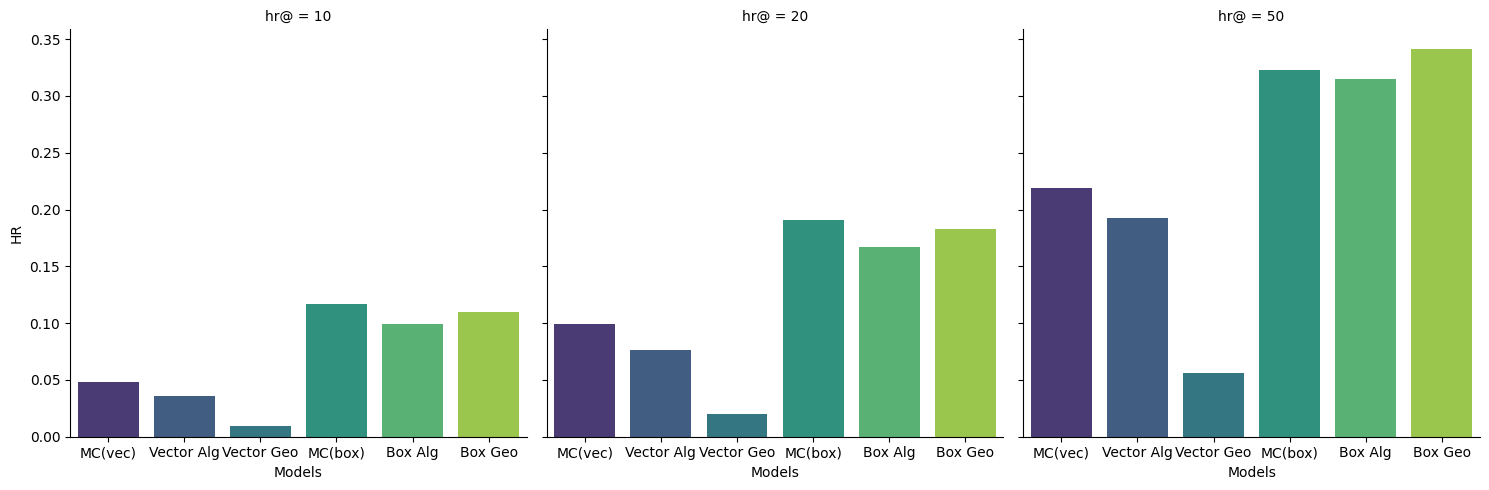

In [275]:
hr_at_10 = []
hr_at_20 = []
hr_at_30 = []
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_vector_mg, 'hr_a_and_u')
hr_at_10, hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_vector_mg, 'hr_u_mult_a')
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_vector_mg, 'hr_u_int_a')
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_box_mg, 'hr_a_and_u')
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_box_mg, 'hr_u_mult_a')
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_box_mg, 'hr_u_int_a')
plot_hits(hr_at_10, hr_at_20, hr_at_30)

### $ U \cap A_1 \cap A_2 $

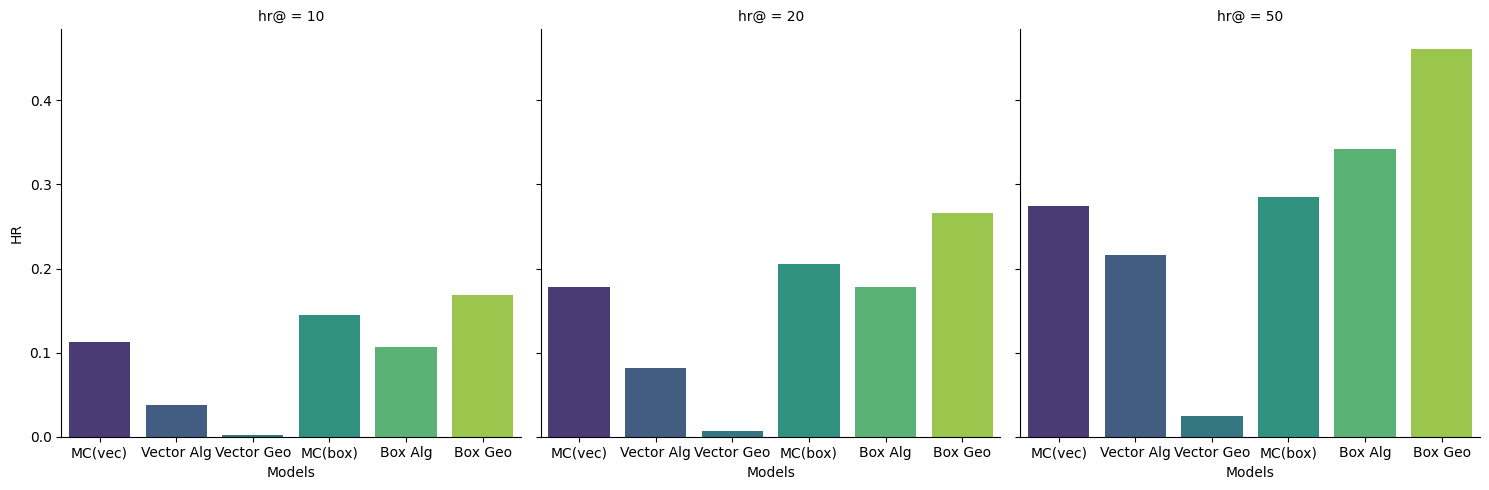

In [276]:
hr_at_10 = []
hr_at_20 = []
hr_at_30 = []
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_vector_mg_a1_a2, 'hr_u_a1_a2_and')
hr_at_10, hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_vector_mg_a1_a2, 'hr_u_a1_a2_mult')
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_vector_mg_a1_a2, 'hr_u_a1_a2_int')
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_box_mg_a1_a2, 'hr_u_a1_a2_and')
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_box_mg_a1_a2, 'hr_u_a1_a2_mult')
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_box_mg_a1_a2, 'hr_u_a1_a2_int')
plot_hits(hr_at_10, hr_at_20, hr_at_30)

### $ U \cap A_1 \cap \neg A_2$

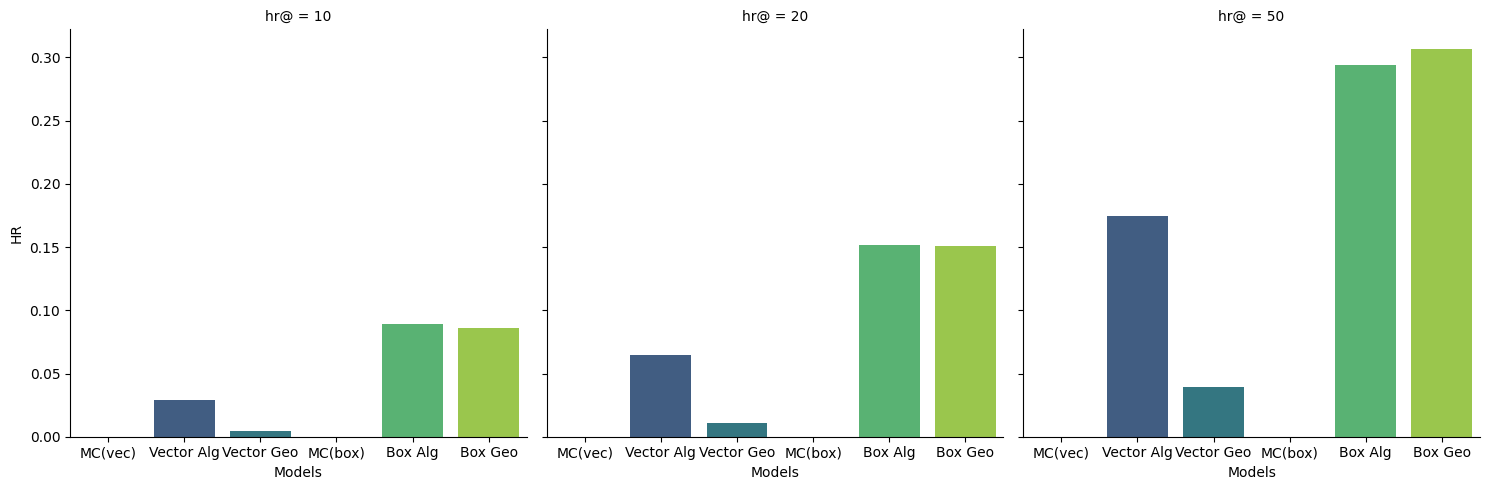

In [277]:
hr_at_10 = []
hr_at_20 = []
hr_at_30 = []
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_vector_mg_a1_not_a2, 'hr_u_a1_not_a2_and')
hr_at_10, hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_vector_mg_a1_not_a2, 'hr_u_a1_not_a2_mult')
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_vector_mg_a1_not_a2, 'hr_u_a1_not_a2_int')
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_box_mg_a1_not_a2, 'hr_u_a1_not_a2_and')
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_box_mg_a1_not_a2, 'hr_u_a1_not_a2_mult')
hr_at_10,hr_at_20, hr_at_30 = append_metrices(hr_at_10, hr_at_20, hr_at_30, metric_dict_box_mg_a1_not_a2, 'hr_u_a1_not_a2_int')
plot_hits(hr_at_10, hr_at_20, hr_at_30)

### Analysis

# Get Results for Movie-Attribute (MA) Joint Matrix

In [117]:
dataset_ma = get_dataset(arg_dict_box_ma)
n_users = dataset_ma.n_users
n_movies = dataset_ma.n_movies
n_attributes = dataset_ma.n_attributes
gt_user_movie_matrix = gt_df_to_matrix(dataset_ma.gt_user_movie, dataset_ma)
gt_attribute_movie_matrix = gt_df_to_matrix(dataset_ma.gt_attribute_movie, dataset_ma)
dataset_ma.read_neg_data_files()
print('Data loaded')
print('Number of users:', n_users)
print('Number of movies:', n_movies)
print('Number of attributes:', n_attributes)
user_attribute_query_ma = pd.read_csv('../' + arg_dict_box_ma['data_dir'] + '/combinations/user_attribute.csv')
user_attributeA_attributeB_ma = pd.read_csv('../' + arg_dict_box_ma['data_dir'] + '/combinations/user_attributeA_attributeB.csv')
user_attributeA_not_attributeB_ma = pd.read_csv('../' + arg_dict_box_ma['data_dir'] + '/combinations/user_attributeA_not_attributeB.csv')
print("Combination queries loaded")

Data files read successfully...
ID files read successfully...
Negative data files read successfully...
Data loaded
Number of users: 6040
Number of movies: 3706
Number of attributes: 426
Combination queries loaded


In [118]:
print("Validation results for box model")
pprint(check_test_results(dataset_ma, model_box_ma))
print("Validation results for vector model")
pprint(check_test_results(dataset_ma, model_vector_ma))

Validation results for box model
{'hr': 0.825634777545929,
 'hr_attr': 0.6666666865348816,
 'ndcg': 0.6161209344863892,
 'ndcg_attr': 0.4339781403541565}
Validation results for vector model
{'hr': 0.8259406685829163,
 'hr_attr': 0.7777777910232544,
 'ndcg': 0.5130804777145386,
 'ndcg_attr': 0.5548930168151855}


## Box $U \cap A$ - Attribute

In [119]:
metric_dict_box_ma = get_ranking_metrices(user_attribute_query_ma, model_box_ma, arg_dict_box_ma)

100%|██████████| 49169/49169 [26:58<00:00, 30.38it/s]


Calculating metrics for user
HR@10: 0.06186825032032378
HR@20: 0.10408997539099839
HR@50: 0.19117736785372896
NDCG: 0.15495761844167802
Calculating metrics for attribute
HR@10: 0.06758323333807888
HR@20: 0.11586568773007383
HR@50: 0.19880412455002136
NDCG: 0.15678126468494405
Calculating metrics for user*attribute
HR@10: 0.06622058614167463
HR@20: 0.11564196953364925
HR@50: 0.20354288271065102
NDCG: 0.15773964735547732
Calculating metrics for user intersection attribute
HR@10: 0.06642396632024243
HR@20: 0.11560129349793569
HR@50: 0.20342085460351034
NDCG: 0.15775946459565418
Calculating metrics for attribute in user
HR@10: 0.06302751733816023
HR@20: 0.10614411519453314
HR@50: 0.19774654762146882
NDCG: 0.14086580383455358
Calculating metrics for attribute and user
HR@10: 0.06302751733816023
HR@20: 0.10614411519453314
HR@50: 0.19764485753218491
NDCG: 0.136456410355126


## Vector $U \cap A$ - Attribute

In [120]:
metric_dict_vector_ma = get_ranking_metrices(user_attribute_query_ma, model_vector_ma, arg_dict_vector_ma)

100%|██████████| 49169/49169 [07:49<00:00, 104.78it/s]


Calculating metrics for user
HR@10: 0.004942138339197462
HR@20: 0.011389289999796619
HR@50: 0.03837783969574325
NDCG: 0.12043463412170731
Calculating metrics for attribute
HR@10: 0.001016900892838984
HR@20: 0.003396448982082206
HR@50: 0.009823262624824585
NDCG: 0.10335727142566449
Calculating metrics for user*attribute
HR@10: 0.010453741178384754
HR@20: 0.02344973458886697
HR@50: 0.0675628953202221
NDCG: 0.12346851606788178
Calculating metrics for user intersection attribute
HR@10: 0.0037015192499339016
HR@20: 0.008663995606988143
HR@50: 0.023165002338872052
NDCG: 0.11051687541770555
Calculating metrics for attribute in user
HR@10: 0.008704671642701702
HR@20: 0.01635176635685086
HR@50: 0.0341271939636763
NDCG: 0.0916161708606459
Calculating metrics for attribute and user
HR@10: 0.006020053285606785
HR@20: 0.008663995606988143
HR@50: 0.010535093249811873
NDCG: 0.087119576325374


## Box $U \cap A_1 \cap A_2$ - Attribute

In [ ]:
metric_dict_box_ma_a1_a2 = get_ranking_metrices_intersection(user_attributeA_attributeB_ma, model_box_ma, arg_dict_box_ma)

## Vector $U \cap A_1 \cap A_2$ - Attribute

In [ ]:
metric_dict_vector_ma_a1_a2 = get_ranking_metrices_intersection(user_attributeA_attributeB_ma, model_vector_ma, arg_dict_vector_ma)

## Box $U \cap A_1 \cap \neg A_2$ - Attribute

In [122]:
metric_dict_box_ma_a1_not_a2 = get_ranking_metrices_difference(user_attributeA_not_attributeB_ma, model_box_ma, arg_dict_box_ma)

100%|██████████| 55570/55570 [34:52<00:00, 26.56it/s] 

Post hoc filtering
HR@10: 0.0
HR@20: 0.0
HR@50: 0.0
NDCG: 0.08434245191231139
Calculating metrics for user*attribute1-not-attribute2
HR@10: 1.0
HR@20: 1.0
HR@50: 1.0
NDCG: 0.6309297535714575
Calculating metrics for user intersection attribute1 - intersection attribute2
HR@10: 1.0
HR@20: 1.0
HR@50: 1.0
NDCG: 1.0


## Vector $U \cap A_1 \cap \neg A_2$ - Attribute

In [123]:
metric_dict_vector_ma_a1_not_a2 = get_ranking_metrices_difference(user_attributeA_not_attributeB_ma, model_vector_ma, arg_dict_vector_ma)

100%|██████████| 55570/55570 [05:48<00:00, 159.57it/s]

Post hoc filtering
HR@10: 0.0
HR@20: 0.0
HR@50: 0.0
NDCG: 0.08434245191231139
Calculating metrics for user*attribute1-not-attribute2
HR@10: 0.0
HR@20: 0.0
HR@50: 0.0
NDCG: 0.13107265131218435
Calculating metrics for user intersection attribute1 - intersection attribute2
HR@10: 0.0
HR@20: 0.0
HR@50: 0.0
NDCG: 0.10422828508334185


In [44]:

keep_top = 200
rank_u = []
rank_a = []
rank_u_mult_a = []
rank_u_int_a = []
rank_a_in_u = []
rank_a_and_u = []
for user_id, attribute_id, movie_id in tqdm(user_attribute_query_mg.values):
    u = torch.tensor([user_id])
    a = torch.tensor([attribute_id + n_users])
    m = torch.tensor([movie_id])

    mask = torch.ones(model_vector_mg.n_items, dtype=torch.bool)
    gt_m = torch.where(gt_u_and_a_matrix_mg[user_id, attribute_id] == 1)[0]
    mask[gt_m] = False
    mask[m] = True

    score_u = model_vector_mg.predict_item(u)
    score_a = model_vector_mg.predict_item(a)

    ## Score multiplication
    if arg_dict_vector_mg['model'] == 'box_conditional':
        score_u_mult_a = score_u + score_a
    elif arg_dict_vector_mg['model'] == 'mf_bias':
        score_u_mult_a = F.logsigmoid(score_u) + F.logsigmoid(score_a)
    
    score_u_mult_a[~mask] = -torch.inf
    order_u_mult_a = torch.argsort(score_u_mult_a, dim=-1, descending=True)

    ## Score intersection
    if arg_dict_vector_mg['model'] == 'box_conditional':
        u_box = model_vector_mg.user_embeddings(u)
        a_box = model_vector_mg.user_embeddings(a)
        u_int_a_box = u_box.intersection(a_box)
        u_int_a_box = u_box.intersection(
                    a_box,
                    intersection_temp=model_vector_mg.intersection_temp,
                    bayesian=True)
        u_int_a_scores = box_predict_conditional(u_int_a_box, model_vector_mg)
    elif arg_dict_vector_mg['model'] == 'mf_bias':
        u_vector = model_vector_mg.user_embeddings(u)
        a_vector = model_vector_mg.user_embeddings(a)
        u_int_a_vector = u_vector + a_vector
        u_int_a_scores = vector_predict(u_int_a_vector, model_vector_mg)
    
    u_int_a_scores[~mask] = -torch.inf
    order_u_int_a = torch.argsort(u_int_a_scores, dim=-1, descending=True)

    ## Get ranks
    rank_u_mult_a.append(torch.where(order_u_mult_a == m)[0].item())
    rank_u_int_a.append(torch.where(order_u_int_a == m)[0].item())

print("Calculating metrics for user*attribute")
hr_u_mult_a, ndcg_u_mult_a = get_hr_ndcg_at_k(rank_u_mult_a)
print("Calculating metrics for user intersection attribute")
hr_u_int_a, ndcg_u_int_a = get_hr_ndcg_at_k(rank_u_int_a)


100%|██████████| 38181/38181 [02:01<00:00, 313.09it/s]


Calculating metrics for user*attribute
HR@10: 0.03619601372410361
HR@20: 0.07660878447395301
HR@50: 0.19226840575155182
NDCG: 0.1513329949401536
Calculating metrics for user intersection attribute
HR@10: 0.009533537623425264
HR@20: 0.020088525706503234
HR@50: 0.05620596631832587
NDCG: 0.12377377183332954
